In [1]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpmax, fpgrowth
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
def get_dataset():
    dataset = []
    csv_file = "../Grocery_Items_21.csv"
    data = pd.read_csv(f"{csv_file}")
    
    for i in range(len(data)):
        row_values = data.iloc[i].values
        items = [item.strip() for item in row_values if pd.notna(item)]
        dataset.append(items)
        
    return dataset

In [3]:
def get_association_rules():    
    dataset = get_dataset()   

    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
    
    print(frequent_itemsets)

In [4]:
get_association_rules()

     support                        itemsets
0   0.121500              (other vegetables)
1   0.060250                 (bottled water)
2   0.110750                    (rolls/buns)
3   0.046125                  (bottled beer)
4   0.037625                   (brown bread)
..       ...                             ...
62  0.014750  (whole milk, other vegetables)
63  0.010250  (rolls/buns, other vegetables)
64  0.012625        (rolls/buns, whole milk)
65  0.010125              (whole milk, soda)
66  0.011000            (yogurt, whole milk)

[67 rows x 2 columns]


In [5]:
def extract_association():
    minimum_support=values = [0.001, 0.005, 0.01, 0.05]
    minimum_confidence_threshold = [0.05, 0.075, 0.1]
    dataset = get_dataset()   

    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = []
    rules = []
    for min_supp in minimum_support:
        for min_thresh in minimum_confidence_threshold:
            frequent_itemsets.append(fpgrowth(df, min_support=min_supp, use_colnames=True))
            rule = association_rules(frequent_itemsets[-1], metric="confidence", min_threshold=min_thresh)
            rules.append([min_supp, min_thresh, len(rule)])
    
    rules = pd.DataFrame(rules, columns=["msv", "mct", "rules"])
    rule = rules.pivot(index="msv", columns="mct", values="rules")
    sns.heatmap(rule, annot=True, fmt=".1f", cmap="crest")

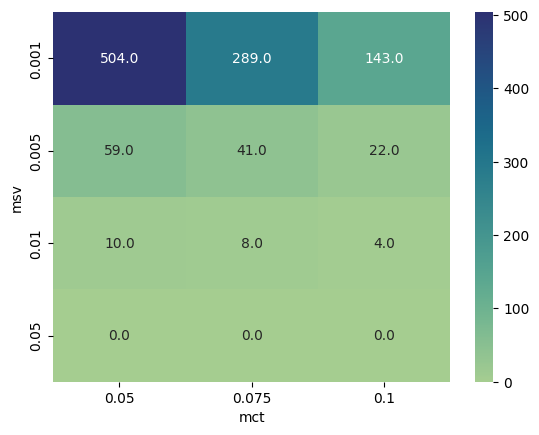

In [6]:
extract_association()

# Image Classification using CNN 

In [14]:
def grayscale_conversion():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collect[folder] = all_files
        
    
    grayscaled_images = {}
    for folder, images in collect.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [15]:
def split_dataset():
    grayscaled_images = grayscale_conversion()
    
    training_set = {}
    testing_set = {}
    for folder in grayscaled_images:
        perce_80 = int(len(grayscaled_images[folder]) * 0.8)
        training_set[folder] = random.sample(grayscaled_images[folder], perce_80)
 
    for folder, images in grayscaled_images.items():
        combine = []
        for img in images:
            if not np.all(np.equal(img, training_set[folder]), axis=1).any():
                combine.append(img)             
        testing_set[folder] = combine
    
    return training_set, testing_set

In [16]:
def train_test_split():
    training_set, testing_set = split_dataset()
    
    X_train, y_train, X_test, y_test = ([] for i in range(4))
    
    count = 0
    for training_folder in training_set:
        for training_image in training_set[training_folder]:
            X_train.append(training_image.ravel())
            y_train.append(count)
        count += 1
    
    count = 0
    for testing_folder in testing_set:
        for testing_image in testing_set[testing_folder]:
            X_test.append(testing_image.ravel())
            y_test.append(count)
        count += 1
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [17]:
def standardized_dataset():
    a, y_train, b, y_test = train_test_split()
     
    standard = StandardScaler()
    X_train = standard.fit_transform(a)
    X_test = standard.transform(b)
        
    return X_train, y_train, X_test, y_test

In [19]:
def images_classifier():
    num_classes = 4
    input_shape = (100, 100, 1)
    
    model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"), 
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Flatten(), 
        layers.Dense(16, activation="relu"), 
        layers.Dense(num_classes, activation="softmax")
    ]
    )
    
    model.summary()
    
    return model

In [20]:
def train_model():
    batch_size = 128
    num_epochs = 30
    model = images_classifier()
    X_train, y_train, X_test, y_test = standardized_dataset()
    
    X_train = np.reshape(X_train, (X_train.shape[0], 100, 100, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 100, 100, 1))
    
    y_train = to_categorical(y_train, num_classes=4)
    y_test = to_categorical(y_test, num_classes=4)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)
    
    return model, X_test, y_test

In [21]:
def model_evaluation():
    model, X_test, y_test = train_model()
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\n\nTest loss:", score[0])
    print("Test accuracy:", score[1])

model_evaluation()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 19208)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                307344    
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 307492 (1.17 MB)
Trainable params: 307492 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [23]:
def plot_learning_curve():
    model,_ ,_ = train_model()
    plt.plot(model.history['accuracy'], label='Training Accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_learning_curve()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 8)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 19208)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                307344    
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 307492 (1.17 MB)
Trainable params: 307492 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

TypeError: 'History' object is not subscriptable